In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [2]:
# Skip date
df1 = pd.read_csv('netflix-prize-data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df2 = pd.read_csv('netflix-prize-data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('netflix-prize-data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('netflix-prize-data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (13160429, 2)
Dataset 2 shape: (26982302, 2)
Dataset 3 shape: (22605786, 2)
Dataset 4 shape: (26851926, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0


In [3]:
df = df1
df = df1.append(df2)
df = df.append(df3)
df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])





Full dataset shape: (89600443, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  2124645     4.0
20000000   198824     3.0
25000000  1094850     1.0
30000000  1414878     2.0
35000000   797705     5.0
40000000  2213342     4.0
45000000  2415495     3.0
50000000   699495     2.0
55000000  1209635     4.0
60000000  2052948     1.0
65000000   438708     5.0
70000000  2020395     5.0
75000000   527559     4.0
80000000   357354     3.0
85000000  2360158     3.0


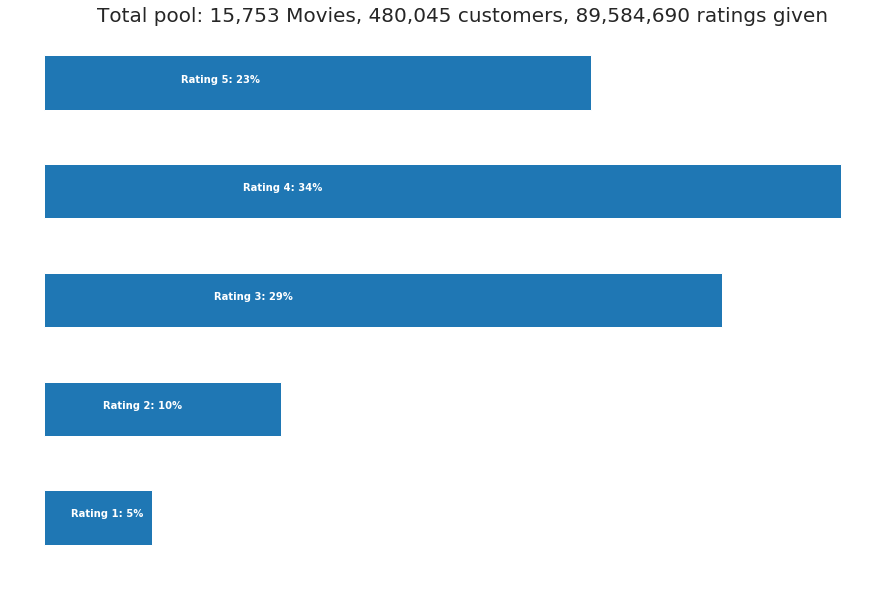

In [5]:

#Groups the data by Ratings
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
count_movie = df.isnull().sum()[1]

# get customer count
count_user = df['Cust_Id'].nunique() - count_movie

# get rating count
count_rating = df['Cust_Id'].count() - count_movie

#UNderstanding the spread of the data
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(count_movie, count_user, count_rating), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [6]:
#Finding the NA values
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))



Movie numpy: [1.0000e+00 1.0000e+00 1.0000e+00 ... 1.5753e+04 1.5753e+04 1.5753e+04]
Length: 89584690


In [7]:
#remove the Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002807  1591210     4.0      2807
20003611  1037347     3.0      3611
25004369   119057     4.0      4369
30005217   408047     5.0      5217
35006187   121619     3.0      6187
40007172  1550676     4.0      7172
45008195  1988250     4.0      8195
50009132   970780     3.0      9132
55010057  2196868     3.0     10057
60010851  1166517     4.0     10851
65011711   204733     3.0     11711
70012533  2420122     5.0     12533
75013216  1287959     3.0     13216
80014164  1136433     5.0     14164
85014977  1260257     3.0     14977


In [8]:
#Remove movie with too less reviews
#Remove customer who give too less reviews
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1971.0
Customer minimum times of review: 188.0


In [9]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (89584690, 3)
After Trim Shape: (63974272, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6969053    736013     3.0      1401
13919241   549416     3.0      2635
20866737   778627     4.0      3771
27954610  1553211     4.0      4885
34806209  2159151     3.0      6154
41689371  1940324     4.0      7574
48600383  2564688     5.0      8911
55701364  1626390     2.0     10144
62858708   905050     3.0     11374
69920017  1102173     3.0     12524
76938236   600170     4.0     13565
84007973  1513097     3.0     14852


In [10]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(144337, 4727)


In [11]:
df_title = pd.read_csv('netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


In [12]:
#making a reader class
#loading the customised dataset by using load from df
#making a SVD model using default values

reader = Reader()


data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)


svd = SVD()
cross_validate(svd, data, measures=['RMSE'])

{'test_rmse': array([0.79456164, 0.79494245, 0.79431138, 0.79440101, 0.79496377]),
 'fit_time': (2977.7218022346497,
  3033.2791504859924,
  3037.8788805007935,
  3032.22230219841,
  3039.186370611191),
 'test_time': (329.0761694908142,
  209.36286687850952,
  255.61565494537354,
  234.80519938468933,
  224.7576024532318)}